### **VERSION 1** 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20
batch_size = 100
learning_rate = 0.0002

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Sigmoid())

# Device setting
D = D.to(device)
G = G.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        # Compute BCELoss using real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images and compute BCELoss
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


100%|██████████| 9912422/9912422 [00:00<00:00, 56557821.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34869226.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26868369.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3720079.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [0/20], Step [200/600], d_loss: 0.1411, g_loss: 4.9488, D(x): 0.94, D(G(z)): 0.04
Epoch [0/20], Step [400/600], d_loss: 0.1091, g_loss: 5.1633, D(x): 0.95, D(G(z)): 0.04
Epoch [0/20], Step [600/600], d_loss: 0.0041, g_loss: 7.5769, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [200/600], d_loss: 0.1045, g_loss: 4.9723, D(x): 0.95, D(G(z)): 0.04
Epoch [1/20], Step [400/600], d_loss: 0.0020, g_loss: 7.8004, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [600/600], d_loss: 0.0008, g_loss: 8.1756, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [200/600], d_loss: 0.0058, g_loss: 7.1287, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [400/600], d_loss: 0.0038, g_loss: 7.6378, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [600/600], d_loss: 0.0321, g_loss: 6.4986, D(x): 0.98, D(G(z)): 0.00
Epoch [3/20], Step [200/600], d_loss: 0.0070, g_loss: 5.6527, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [400/600], d_loss: 0.0066,

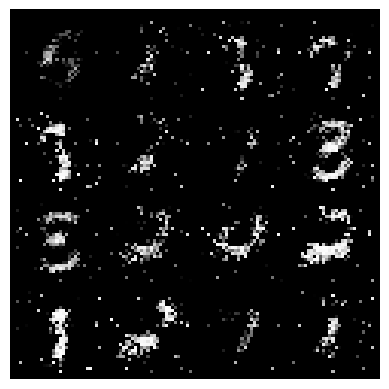

In [23]:
import numpy as np
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    fake_images = G(z).reshape(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(fake_images, nrow=4)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

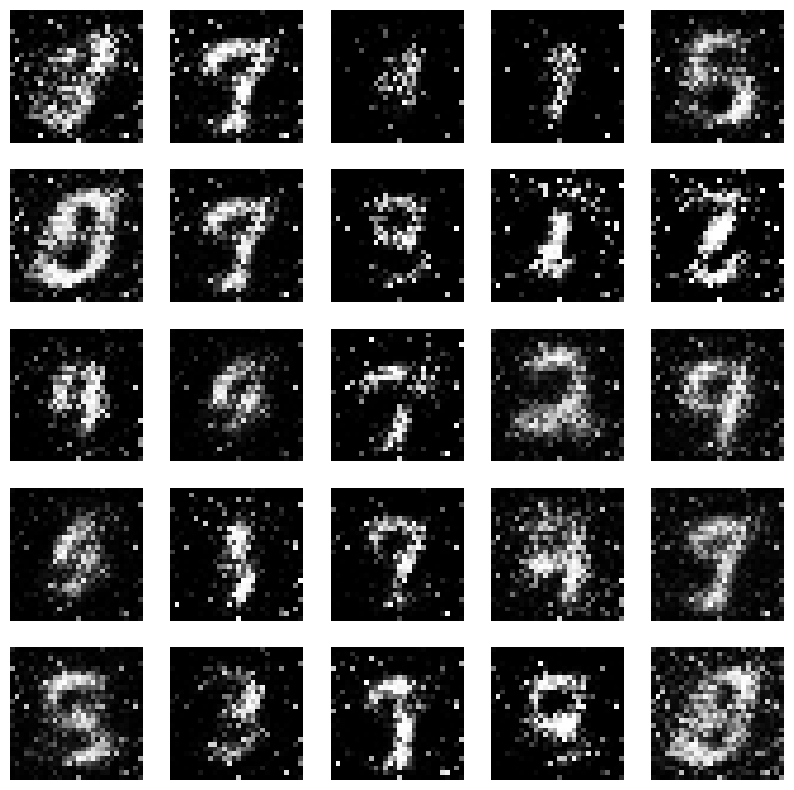

In [24]:
# Generate a batch of images
z = torch.randn(25, latent_size).to(device)
fake_images = G(z)

# Denormalize images
fake_images = fake_images * 0.5 + 0.5

# Reshape the array into a 25x1 grid of images
fake_images = fake_images.reshape(25, 1, 28, 28)

# Convert to numpy array
fake_images = fake_images.cpu().detach().numpy()

# Plot the images
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(fake_images[i*5+j, 0], cmap='gray')
        axs[i,j].axis('off')

plt.show()

In [3]:
# Generate images
import torchvision
with torch.no_grad():
  z = torch.randn(16, latent_size).to(device)
  fake_images = G(z).reshape(-1, 1, 28, 28)
  torchvision.utils.save_image(fake_images, 'generated_images.png', nrow=4)

### **VERSION 2**

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 100
learning_rate = 0.0002

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size), # Updated size
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        # Compute BCELoss using real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images and compute BCELoss
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

Epoch [0/20], Step [100/600], d_loss: 0.4681, g_loss: 1.9491, D(x): 0.88, D(G(z)): 0.28
Epoch [0/20], Step [200/600], d_loss: 0.0425, g_loss: 3.9354, D(x): 1.00, D(G(z)): 0.04
Epoch [0/20], Step [300/600], d_loss: 0.1694, g_loss: 3.3252, D(x): 0.96, D(G(z)): 0.12
Epoch [0/20], Step [400/600], d_loss: 0.0523, g_loss: 5.9350, D(x): 0.99, D(G(z)): 0.04
Epoch [0/20], Step [500/600], d_loss: 0.0450, g_loss: 4.7327, D(x): 0.98, D(G(z)): 0.02
Epoch [0/20], Step [600/600], d_loss: 0.1582, g_loss: 4.1429, D(x): 0.94, D(G(z)): 0.08
Epoch [1/20], Step [100/600], d_loss: 0.0313, g_loss: 5.3126, D(x): 1.00, D(G(z)): 0.03
Epoch [1/20], Step [200/600], d_loss: 0.0593, g_loss: 4.8565, D(x): 0.98, D(G(z)): 0.03
Epoch [1/20], Step [300/600], d_loss: 0.4669, g_loss: 3.3719, D(x): 0.92, D(G(z)): 0.29
Epoch [1/20], Step [400/600], d_loss: 0.3289, g_loss: 4.8927, D(x): 0.91, D(G(z)): 0.15
Epoch [1/20], Step [500/600], d_loss: 0.1665, g_loss: 4.5563, D(x): 0.95, D(G(z)): 0.09
Epoch [1/20], Step [600/600], d_

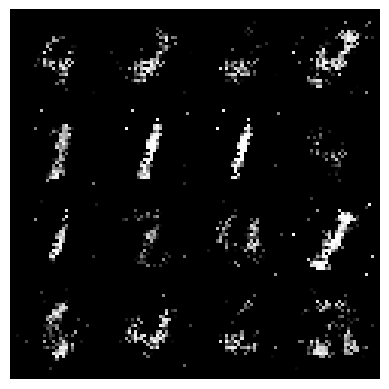

In [13]:
import numpy as np
with torch.no_grad():
  z = torch.randn(16, latent_size).to(device)
  fake_images = G(z).reshape(-1, 1, 28, 28)
  grid = torchvision.utils.make_grid(fake_images, nrow=4)
  plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
  plt.axis('off')
  plt.show()

### **VERSION 3**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 10
hidden_size = 256
image_size = 784
num_epochs = 100
batch_size = 100
learning_rate = 0.0002

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size), # Updated size
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        # Compute BCELoss using real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images and compute BCELoss
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

100%|██████████| 9912422/9912422 [00:00<00:00, 84690071.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46412143.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22838442.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14929881.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [0/100], Step [100/600], d_loss: 0.2901, g_loss: 2.3653, D(x): 0.95, D(G(z)): 0.21
Epoch [0/100], Step [200/600], d_loss: 0.0466, g_loss: 3.9184, D(x): 0.99, D(G(z)): 0.04
Epoch [0/100], Step [300/600], d_loss: 0.3835, g_loss: 3.0543, D(x): 0.93, D(G(z)): 0.25
Epoch [0/100], Step [400/600], d_loss: 0.0485, g_loss: 6.1444, D(x): 0.99, D(G(z)): 0.03
Epoch [0/100], Step [500/600], d_loss: 0.0236, g_loss: 5.1659, D(x): 1.00, D(G(z)): 0.02
Epoch [0/100], Step [600/600], d_loss: 0.0399, g_loss: 5.3630, D(x): 0.99, D(G(z)): 0.03
Epoch [1/100], Step [100/600], d_loss: 0.0764, g_loss: 5.9773, D(x): 0.99, D(G(z)): 0.07
Epoch [1/100], Step [200/600], d_loss: 0.0415, g_loss: 7.1257, D(x): 0.98, D(G(z)): 0.02
Epoch [1/100], Step [300/600], d_loss: 0.0268, g_loss: 6.8136, D(x): 0.99, D(G(z)): 0.02
Epoch [1/100], Step [400/600], d_loss: 0.0348, g_loss: 6.7646, D(x): 0.98, D(G(z)): 0.01
Epoch [1/100], Step [500/600], d_lo